# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [119]:
from bs4 import BeautifulSoup
from itertools import chain
from collections import Counter
from nltk.corpus import stopwords
import urllib
from lxml import html
import numpy as np
import requests
import pandas as pd
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import requests_cache
requests_cache.install_cache('demo_cache')
import math
from matplotlib import pyplot
import statsmodels
from scipy.interpolate import interp1d
import warnings
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api
import numpy as np
import collections
import sqlite3 as sql
import os
from matplotlib import pyplot as plt
import fiona
import geopandas as gpd
import geocoder
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import zipcode

In [120]:
os.chdir('/Users/zhangyunbai/Desktop')

In [121]:
db = sql.connect('sf_data.sqlite')

In [122]:
crime_df = pd.read_sql("SELECT * FROM crime",db)
location = pd.read_sql("SELECT * FROM mobile_food_locations",db)
schedule = pd.read_sql("SELECT * FROM mobile_food_schedule",db)
permits = pd.read_sql("SELECT * FROM mobile_food_permits",db)
noise_df = pd.read_sql("SELECT * FROM noise",db)
parking = pd.read_sql("SELECT * FROM parking",db)
parks = pd.read_sql("SELECT * FROM parks",db)
schools = pd.read_sql("SELECT * FROM schools",db)
zillow = pd.read_sql("SELECT * FROM zillow",db)

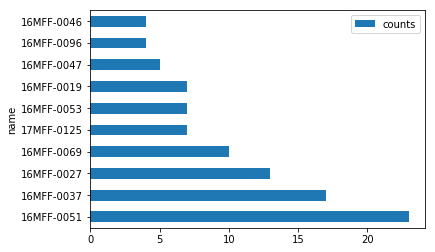

In [123]:
mobilefood = pd.read_sql("SELECT L.permit, L.Status, R.locationid "
                        "FROM mobile_food_permits AS L INNER JOIN mobile_food_schedule AS R ON L.permit = R.permit",db)
mobilefood = mobilefood.loc[mobilefood["Status"] == "APPROVED"]
mobilefood = mobilefood.drop_duplicates()
count_df = pd.DataFrame(mobilefood.groupby('permit').size().rename('counts'))
mobilefood = count_df.sort_values('counts', axis=0, ascending=False).head(10)
mobilefood['name'] = mobilefood.index
mobilefood.index = [range(10)]
mobilefood.plot(x = 'name', y = 'counts', kind = 'barh')
plt.show()

In [124]:
permits.loc[permits['permit'] == '16MFF-0051']

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
3,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00


<strong>
From the plot, we can see that the food vendor with permit '16MEFF-0051' sell at the most location. The applicant for this food vendor is Park's Catering.
</strong>

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

<h4>Question 1: Which parts of the city are the most and least expensive?</h4>


<strong>
Introduction: We want to find out the distribution of different price level house. Then we want to find which is the most and least expensive.
<strong>

<strong>
Stategy:
* First, we extract the house price of 2015 and calculate the average house price. The reason is that there are much fewer data of house price in 2016 or 2017 than in 2015, and data in 2015 is relatively the latest. 
* Use shapefiles to find the location polygon.
* Find the most expensive house price area and the most cheapest area. 
* Draw the map

In [103]:
zips = gpd.read_file("cb_2015_us_zcta510_500k.shp")
houseprice_2015 = pd.read_sql("SELECT RegionName, AVG(MedianSoldPricePerSqft_AllHomes) AS Avg_Pri "
                         "FROM zillow WHERE Date LIKE '2015%' AND MedianSoldPricePerSqft_AllHomes IS NOT NULL "
                         "GROUP BY RegionName ",db)
#choose all house price of 2015 and calculate the average price 

houseprice_2015_1 = houseprice_2015.sort_values(by = 'Avg_Pri')
ex_zip = []
chp_zip = []
SF_COORDINATES = folium.Map(location = [37.7749, -122.4194])

for index in range(0,2): # find 8 most expensive region and the cheapest region
    ex_zip.append(str(int(houseprice_2015_1.iloc[-index-1]['RegionName'])))
    chp_zip.append(str(int(houseprice_2015_1.iloc[index]['RegionName'])))

for zip_code in ex_zip:
    SF_COORDINATES.choropleth(geo_str = zips[zips.ZCTA5CE10.str.startswith(str(zip_code))]['geometry'].to_json(),fill_color='Red')

for zip_code in chp_zip:
    SF_COORDINATES.choropleth(geo_str = zips[zips.ZCTA5CE10.str.startswith(str(zip_code))]['geometry'].to_json(),fill_color='Blue')
print('Expensive(showed as dark red color)')
print ex_zip # expensive house price area
print('Cheap(showed as blue color)')
print chp_zip # cheap house price area
fig = folium.Figure(width = 700, height = 500)
fig.add_child(SF_COORDINATES)

Expensive(showed as dark red color)
['94123', '94105']
Cheap(showed as blue color)
['94080', '94124']


In [126]:
zips = gpd.read_file("cb_2015_us_zcta510_500k.shp")
houseprice_2015 = pd.read_sql("SELECT RegionName, AVG(MedianSoldPricePerSqft_AllHomes) AS Avg_Pri "
                         "FROM zillow WHERE Date LIKE '2015%' AND MedianSoldPricePerSqft_AllHomes IS NOT NULL "
                         "GROUP BY RegionName ",db)
#choose all house price of 2015 and calculate the average price 

houseprice_2015_1 = houseprice_2015.sort_values(by = 'Avg_Pri')
ex_zip = []
chp_zip = []
SF_COORDINATES = folium.Map(location = [37.7749, -122.4194])

for index in range(0,10): # find 10 most expensive region and the cheapest region
    ex_zip.append(str(int(houseprice_2015_1.iloc[-index-1]['RegionName'])))
    chp_zip.append(str(int(houseprice_2015_1.iloc[index]['RegionName'])))

for zip_code in ex_zip:
    SF_COORDINATES.choropleth(geo_str = zips[zips.ZCTA5CE10.str.startswith(str(zip_code))]['geometry'].to_json(),fill_color='Red')

for zip_code in chp_zip:
    SF_COORDINATES.choropleth(geo_str = zips[zips.ZCTA5CE10.str.startswith(str(zip_code))]['geometry'].to_json(),fill_color='Blue')
print('Expensive showed as dark red color')
print ex_zip # expensive house price area
print('Cheap showed as blue color')
print chp_zip # cheap house price area
fig = folium.Figure(width = 700, height = 500)
fig.add_child(SF_COORDINATES)

Expensive showed as dark red color
['94123', '94105', '94158', '94114', '94133', '94102', '94117', '94109', '94107', '94115']
Cheap showed as blue color
['94080', '94124', '94134', '94132', '94112', '94116', '94122', '94121', '94127', '94118']


<em>
Conclusion:
The high price level houses are located in the north-east of San Francisco; the low price level houses are located in the western and southern part of SF. The most expensive region is with zipcode '94123', '94105'; the most cheapest region is with zipcode '94080', '94124'. In the following question, we will find out the reason that affect the house price level.
</em>

<h4>Question 2:
Which parts of the city are the most dangerous place in San Francisco? Is that related to the house price?
</h4>

<strong>
Introduction:

Intuitively, we think of crime rate will have a negative relationship with house price, people are incline to choose safe and comfortable place for living. So the demand of area of low crime rate will push house price keep high. Our goal is to test whether our intuition is accurate.
</strong>

<strong>
Stategy:   
We extract the serious crime -- Assault and Robbery, which I think is most dangerous crime that may hurt one's life. 
First, draw the folium map to see which parts of San Francisco is most dangerous, and then analyze the relationship with house price.
<strong>

In [127]:
# Heavy crime distribution
crimedf = pd.read_sql("SELECT crime.PdDistrict FROM crime WHERE Category = 'ASSAULT' OR Category = 'ROBBERY'",db)
crimedf1 = pd.DataFrame(crimedf['PdDistrict'].value_counts().astype(float))
crime = crimedf1.sort_values('PdDistrict', axis = 0, ascending = False)
crime = crime.reset_index()
crime.columns = ['Location', 'Count']
SF_COORDINATES = (37.7749, -122.4194)


district_geo = r'sfpddistricts.geojson'
map1 = folium.Map(location=SF_COORDINATES, zoom_start=12)# Creat a folium map of SF
map1.choropleth(
    geo_path = district_geo,
    data = crime,
    columns = ['Location', 'Count'],
    key_on = 'feature.properties.DISTRICT',
    fill_color = 'YlGn',
    fill_opacity = 0.7,
    line_opacity = 0.4,
    legend_name = 'Number of LARCENY/THEFT incidents per district')
fig = folium.Figure(width = 700, height = 500)
fig.add_child(map1)

<em>
Conclusion:
From the graph, we can see that the relatively dangerous area is north-east of SF, and the safest place is the western of SF. The SF downtown is the most dangerous place. Surprisely, the house price of north-east is higher than other parts in SF which is contradictive with our hypothesis. Therefore, there maybe any other factors counteract with the fator crime rate.
</em>

<h4>Question 3: Is there a relationship between housing prices and any of the other tables(school, noise)? </h4>

<strong>
* Question Introduction:   
For the previous question, we find surprisely that high crime rate area has high house price. In this question I want to figure out other factors that result the high house price</strong>

<strong>
Strategy:           
* I want to find the relationship between housing prices and the distribution of school. Intuitively, from the common sense, the area that near school cluster will have a relatively higher house price than other areas. Also, I use elementary, middle and high schools to denote "school". The reason is that I think undergraduate students and graduate students are incline to rent the houses but to buy them. Therefore, I want to test whether distribution of schools and high house price have some similiarities.
* I want to find the relationship between housing prices and the distribution of incidences of noise. From common sense, the noise area or street implies that this place is prosperous. And the more prosperous the area is, the more higher house price it is. Therefore, we want to test whether distribution of noise incidence and high house price have some similiarities.
* First, I extract the latitude and longitude of schools.(lower grade 0-9), and extract vehicle_car_alarm.
* Second, using folium map to find out the distribution of schools and noise.

In [128]:
school_inf = pd.read_sql("SELECT Name, Lat, Lon FROM schools WHERE LowerGrade BETWEEN 0 AND 9",db)
lonlat1 = pd.concat([school_inf['Lat'], school_inf['Lon']], axis = 1)
SF_COORDINATES = (37.7749, -122.4194)
map_1 = folium.Map(SF_COORDINATES, zoom_start=5)
marker_cluster = folium.MarkerCluster("School cluster").add_to(map_1)
for each in lonlat1.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster)
map_1

<em>
Conclusion:     
From problem 1, we know that the area that with zip code '94123', '94105', '94158' has relatively high house price. Near the zone "94123" and "94105", which is in the north of San Francisco, there are many element, middle and high schools. Also, there are few schools in the area "94080" which is the South San Francisco. Simutaneously, the house price of this place is relatively low. So we can infer that there is a positive relationship between number of schools(element, middle, and high school) and the house price. I guess from the perspective of most parents and students, they want to live near the schools for convenience. Then demand for the houses which are near schools will keep high. As a result, the house price near school become relatively high. 
</em>

In [129]:
noise = pd.read_sql("SELECT Lat,Lon FROM noise WHERE Type = 'vehicle_car_alarm'",db)
noise = noise.dropna()
map_2 = folium.Map(SF_COORDINATES, zoom_start=5)
marker_cluster = folium.MarkerCluster("Noise cluster").add_to(map_2)
for each in noise.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster)
map_2

<em>
The distribution of noise congregate in downtown area, which is as our expectation. The reason for that is it is the most properous and busiest area of SF. Simutaneously, house price of this area is relatively high. One exception is that in the western part of SF, the noise incidence is high, however, the house price is low. Therefore, overall noise  is also a factor account for the house price reason.
</em>

<h4> Question 4: What is the relationship between crime rate and high level noise region?</h4>

<strong>
Intuitively, in people's mind, the light crime will happen in relatively properous place; the heavy crime will happen in the sparsely populated place. We use "noise" as an indicator to test whether our intuision is true.
</strong>

In [130]:
# Light crime event distribution
crimedf = pd.read_sql("SELECT crime.PdDistrict FROM crime WHERE Category = 'LARCENY/THEFT'",db)
crimedf1 = pd.DataFrame(crimedf['PdDistrict'].value_counts().astype(float))
crime = crimedf1.sort_values('PdDistrict', axis = 0, ascending = False)
crime = crime.reset_index()
crime.columns = ['Location', 'Count']
SF_COORDINATES = (37.7749, -122.4194)

district_geo = r'sfpddistricts.geojson'
map1 = folium.Map(location=SF_COORDINATES, zoom_start=12)# Creat a folium map of SF
map1.choropleth(
    geo_path = district_geo,
    data = crime,
    columns = ['Location', 'Count'],
    key_on = 'feature.properties.DISTRICT',
    fill_color = 'YlGn',
    fill_opacity = 0.7,
    line_opacity = 0.4,
    legend_name = 'Number of LARCENY/THEFT incidents per district')
fig = folium.Figure(width = 700, height = 500)
fig.add_child(map1)

In [65]:
# map of noise incidence distribution
noise = pd.read_sql("SELECT Lat,Lon FROM noise",db)
noise = noise.dropna()
map_2 = folium.Map(SF_COORDINATES, zoom_start=5)
marker_cluster = folium.MarkerCluster("Noise cluster").add_to(map_2)
for each in noise.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster)
map_2

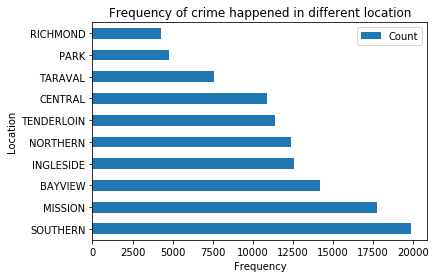

In [62]:
crime.plot(x = 'Location', y = 'Count', fontsize = 10, kind = 'barh', title = 'Frequency of crime happened in different location')
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.show()

<em>
Conclusion:   
* From the "barh" plot, we can see that the most dangerous place is Southern and Mission area. The most noisy place is near Mission. From the light-crime map, as our expectation, most LARCENY/THEFT is happened in Mission area, which is also the most noisy area. From the heavy-crime map, we can see that the frequency of Assault and Rob happens in south of SF frequency, which is the lowest noisy place. The reason maybe is that there are a few people living here, so the regulation and control of this place is not fulfilled. 
* The interesting thing is that the SF downtown is the most dangerous place, no matter the heavy crime and light crime. Hence, the noise level which indicates the properous level and population level, is highly related to the crime rate in San Francisco.
</em>

<h4> Question 5: What is the relationship between parking locations and vehicle car noise?</h4>

<strong>
Usually, we think that near the parking place, the noise may be created by the car coming and going. Hence, I am wondering is there any relationship between parking locations and vehicle car noise.</strong>

<strong> Strategy:
* First, I extract the non-private parking area. 
* Use the folium map to find the map of non-private parking area.
* Compare this distribution to the distribution of high noise region.

In [131]:
parking = pd.read_sql("SELECT Lat,Lon FROM parking WHERE Owner != 'Private'",db)
map_3 = folium.Map(SF_COORDINATES, zoom_start=5)
marker_cluster = folium.MarkerCluster("Noise cluster").add_to(map_3)
for each in parking.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster)
map_3

<em>
From the map, we can see that there are three non-private parking clusters. One is near the north of SF. The other two is near the Mission area. From previous graph, we know that Mission area is the most noisy place in San Francisco. The reason maybe is that there are many holiday resort near in the north of San Francisco, such as Fisherman's Wharf and Golden State Bridge. Also, Union Square is near downtown. Therefore, there are many people driving here for holiday, and so they need parking place. As a result, there are many people and vehicle in the non-private parking area. Hence, we can infer from that the noise level is related to the non-private parking area.
</em>